In [ ]:
#hide
#skip
%config Completer.use_jedi = False
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
# default_exp agents.dqn.targets

In [ ]:
# export
# Python native modules
import os
from collections import deque
from typing import *
# Third party libs
import torch
from torch.nn import *
from fastcore.all import *
from fastai.learner import *
from fastai.torch_basics import *
from fastai.torch_core import *
from fastai.callback.all import *
# Local modules
from fastrl.data.block import *
from fastrl.agent import *
from fastrl.core import *
from fastrl.agents.dqn.core import *

# DQN Targets + N-Step
> A Bare-Bones DQN is usually extremely unstable. Target models can eleviate this. We also support First-Last N steps better.

The first part of the algorithm is the actual categorical DQN section. There are 2 parts
to this:<br>
    - defined supports<br>
    - model output balancing

This section is composed of 2 important equations:

$z_i = V_{min} + i\Delta z: 0 \leq i < N$

where

$\Delta z = \frac{V_{max} - V_{min}}{N - 1}$

Defines the support distribution, in other words, how the activations of the neural network output is going to be weighted.


In [ ]:
# export
def supports(n_atoms=51,v_min=-1,v_max=1)->Tuple[Tensor,float]: 
    delta_z=v_max-v_min/n_atoms
    return (v_min+Tensor([i*delta_z for i in range(n_atoms)])),delta_z

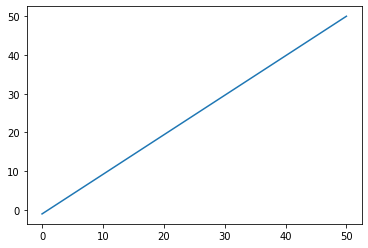

In [ ]:
import matplotlib.pyplot as plt

out,delta_z=supports()
plt.plot(out.numpy())

$Z_{\theta}(x,a) = z_i \quad w.p. \: p_i(x,a) := \frac{e^{\:\theta_i(x,a)}} {\sum_j{e^{\:\theta_i(x,a)}}}$ 

Now that we have defined how the supports are defind, we also define the head of the neural model.

In [ ]:
# export
def distribution_head(t): 
    denom=torch.exp(t).sum()
    return torch.exp(t)/denom    

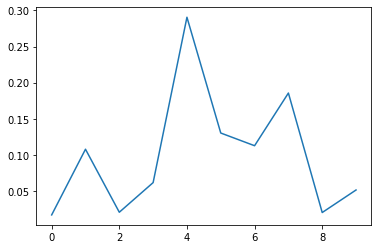

In [ ]:
out=distribution_head(torch.randn((10,)))
plt.plot(out.numpy())

In [ ]:
# export
class CategoricalDQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512,n_atoms=51,
                 v_min=-1,v_max=1):
        store_attr()
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)

In [ ]:
CategoricalDQN(4,2)

CategoricalDQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [ ]:
# export
class DQNTargetTrainer(Callback):
    
    def __init__(self,n_batch=0,target_sync=300,discount=0.99,n_steps=1):
        store_attr()
        self._yb=None  
        
    def before_fit(self):
        self.learn.target_model=deepcopy(self.learn.model.model)
        self.n_batch=0
    
    def after_pred(self):
        self.learn.yb=self.yb[0]
        self._yb=({k:v.clone() for k,v in self.yb.items()},)
        self.learn.done_mask=self.yb['done'].reshape(-1,)
        self.learn.next_q=self.target_model(self.yb['next_state']).max(dim=1).values.reshape(-1,1)
        self.learn.next_q[self.done_mask]=0
        self.learn.targets=self.yb['reward']+self.learn.next_q*(self.discount**self.n_steps)
        self.learn.pred=self.learn.model.model(self.yb['state'])
        t_q=self.pred.clone()
        t_q.scatter_(1,self.yb['action'],self.targets)
        self.learn.yb=(t_q,)
        
    def before_backward(self): self.learn.yb=self._yb
        
    def after_batch(self):
        if self.n_batch%self.target_sync==0:
            self.target_model.load_state_dict(self.learn.model.state_dict())
        self.n_batch+=1

In [ ]:
dqn=DQN(4,2)
agent=Agent(dqn,cbs=[ArgMaxFeed,DiscreteEpsilonRandomSelect])
source=Src('CartPole-v1',agent,seed=0,steps_count=1,n_envs=1,steps_delta=1,cbs=[GymSrc,FirstLast])

dls=SourceDataBlock(
    blocks=SourceBlock(source)
).dataloaders([source],n=1000,bs=1,num_workers=0)

learn=Learner(dls,agent,loss_func=MSELoss(),
              cbs=[ExperienceReplay(bs=32,max_sz=100000,warmup_sz=32),DQNTargetTrainer],
              metrics=[Reward,Epsilon])

In [ ]:
slow=True
learn.fit(3 if slow else 47,lr=0.0001,wd=0)

KeyboardInterrupt: 

In [ ]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbdev.cli import make_readme
    make_readme()
    notebook2script()
    notebook2html()